In [56]:
# import library
%matplotlib inline
# Download the necessary corpora for TextBlob/NLTK
# !python -m textblob.download_corpora
import pandas as pd
import nltk
import numpy as np
from textblob import TextBlob
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import _pickle as cPickle
from scipy.io import loadmat
from sklearn.svm import SVC
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer,TfidfTransformer
# Corrected import for train_test_split
from sklearn.model_selection import train_test_split # Use model_selection instead of cross_validation
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
# Corrected import for GridSearchCV and StratifiedKFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Use model_selection instead of grid_search and cross_validation
# Corrected import for cross_val_score
from sklearn.model_selection import cross_val_score # Use model_selection instead of cross_validation
# Corrected import for learning_curve
from sklearn.model_selection import learning_curve # Use model_selection instead of learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

In [14]:
df=pd.read_csv("Training.txt",sep="\t", names=['liked','text'],encoding="utf-8");
df.head(3)

,liked,text
0,1,India is developing countries
1,1,The Da Vinci Code book is just awesome.
2,1,this was the first clive cussler i've ever rea...


In [15]:
print(len(df))

6931


In [17]:
df.groupby('liked').describe()

text                                  
      count unique                   top freq
liked                                        
0      2975    559  I hate Harry Potter.   85
1      3956    744  I love Harry Potter.  167

In [27]:
def tokens(review):
    return TextBlob(review).words

df.head().text.apply(tokens)

,text
0,"[India, is, developing, countries]"
1,"[The, Da, Vinci, Code, book, is, just, awesome]"
2,"[this, was, the, first, clive, cussler, i, 've..."
3,"[i, liked, the, Da, Vinci, Code, a, lot]"
4,"[i, liked, the, Da, Vinci, Code, a, lot]"


In [28]:
TextBlob("ready was not a good movie").tags
#nltk.help.upenn_tagset('JJ')

[('ready', 'NN'),
 ('was', 'VBD'),
 ('not', 'RB'),
 ('a', 'DT'),
 ('good', 'JJ'),
 ('movie', 'NN')]

In [29]:
def to_lemmas(review):
    wordss = TextBlob(review.lower()).words
    # for each word, take its "base form" = lemma
    return [word.lemma for word in wordss]

df.text.head().apply(to_lemmas)

,text
0,"[india, is, developing, country]"
1,"[the, da, vinci, code, book, is, just, awesome]"
2,"[this, wa, the, first, clive, cussler, i, 've,..."
3,"[i, liked, the, da, vinci, code, a, lot]"
4,"[i, liked, the, da, vinci, code, a, lot]"


In [30]:
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()
lmtzr.lemmatize('octopi')
#nltk

'octopus'

In [42]:
bow_transformer = CountVectorizer(analyzer=to_lemmas).fit(df['text'])
print(len(bow_transformer.vocabulary_))

2114


In [33]:
review1=df['text'][10]
print(review1)
#to check 3rd document/review in collection/database

I thought the Da Vinci Code was a pretty good book.


In [38]:
bow=bow_transformer.transform([review1])
print(bow)
bow.shape

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 11 stored elements and shape (1, 2114)>
  Coords	Values
  (0, 42)	1
  (0, 249)	1
  (0, 369)	1
  (0, 458)	1
  (0, 811)	1
  (0, 950)	1
  (0, 1461)	1
  (0, 1838)	1
  (0, 1862)	1
  (0, 1977)	1
  (0, 1984)	1


(1, 2114)

In [46]:
print(bow_transformer.get_feature_names_out()[372])
#to check 372nd word in collection

code-other


In [47]:
review_bow = bow_transformer.transform(df['text'])
print( 'sparse matrix shape:', review_bow.shape)
print('number of non-zeros:', review_bow.nnz) #learn this
print( 'sparsity: %.2f%%' % (100.0 * review_bow.nnz))

sparse matrix shape: (6931, 2114)
number of non-zeros: 71297
sparsity: 7129700.00%


In [48]:
tfidf_transformer =TfidfTransformer().fit(review_bow)
review_tfidf = tfidf_transformer.transform(review_bow)
review_tfidf.shape

(6931, 2114)

In [49]:
text_train, text_test, liked_train, liked_test = train_test_split(df['text'], df['liked'], test_size=0.2)
print(len(text_train), len(text_test), len(text_train) , len(text_test))

5544 1387 5544 1387


In [61]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=to_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),
])

In [62]:

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

In [64]:
grid_svm = GridSearchCV(
    pipeline_svm, #object used to fit the data
    param_grid=param_svm,
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores" i.e. to run on all CPUs
    scoring='accuracy',#optimizing parameter
    cv=StratifiedKFold(n_splits=5), # Changed n_folds to n_splits and removed liked_train as it's not needed here
)


In [67]:
%time classifier = grid_svm.fit(text_train, liked_train) # find the best combination from param_svm
print(classifier.cv_results_)

CPU times: user 1.85 s, sys: 143 ms, total: 2 s
Wall time: 1min 37s
{'mean_fit_time': array([1.91291828, 1.59321437, 1.44408264, 1.66222239, 5.37475295,
       5.22593141, 2.90425196, 3.56080828, 1.57571092, 2.91328945,
       1.64322906, 1.56082702]), 'std_fit_time': array([0.50892774, 0.23566664, 0.02197148, 0.21051584, 0.51665439,
       1.31130789, 0.36850764, 0.30866165, 0.01281043, 0.30398978,
       0.22834782, 0.04892651]), 'mean_score_time': array([0.42723932, 0.38726029, 0.34624643, 0.42664981, 1.13980627,
       1.01747994, 0.63108377, 0.75148144, 0.43351407, 0.63458939,
       0.46606421, 0.37770882]), 'std_score_time': array([0.09966578, 0.0742847 , 0.01414777, 0.09034508, 0.22895254,
       0.27982277, 0.02159824, 0.083904  , 0.05915879, 0.01154211,
       0.12883114, 0.05698068]), 'param_classifier__C': masked_array(data=[1, 10, 100, 1000, 1, 1, 10, 10, 100, 100, 1000, 1000],
             mask=[False, False, False, False, False, False, False, False,
                   Fa

In [68]:
print(classification_report(liked_test, classifier.predict(text_test)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       576
           1       0.99      1.00      0.99       811

    accuracy                           0.99      1387
   macro avg       0.99      0.99      0.99      1387
weighted avg       0.99      0.99      0.99      1387



In [69]:
print(classifier.predict(["the vinci code is awesome"])[0])

1


In [70]:
print(classifier.predict(["the vinci code is bad"])[0])


0


In [71]:
def gaussKernel(x1, x2, sigma):
    ss=np.power(sigma,2)
    norm= (x1-x2).T.dot(x1-x2)
    return np.exp(-norm/(2*ss))
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2
gaussKernel(x1,x2,sigma)

np.float64(0.32465246735834974)

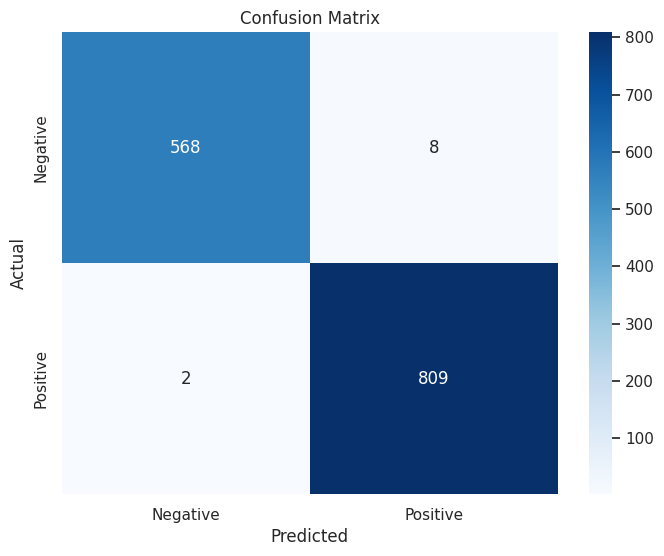

In [79]:
cm = confusion_matrix(liked_test, classifier.predict(text_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

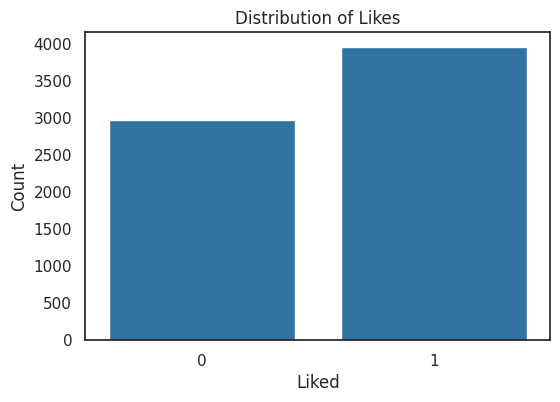

In [84]:
# Visualize the distribution of likes
plt.figure(figsize=(6, 4))
sns.countplot(x='liked', data=df)
plt.title('Distribution of Likes')
plt.xlabel('Liked')
plt.ylabel('Count')
plt.show()

In [78]:
best_params = classifier.best_params_
print("\nBest parameters found by GridSearchCV:")
best_params


Best parameters found by GridSearchCV:


{'classifier__C': 1, 'classifier__kernel': 'linear'}